# Домашнее задание №1

## Постановка задачи

1. Используется [датасет](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) с данными об одобрении кредитов. Содержит бинарные, категориальные и числовые признаки; также содержит пропущенные данные.
2. Задача - бинарная классификация, целевой признак - последний столбец (A16); показывает - одобрен кредит или нет.
3. Функция потерь - бинарная кроссэнтропия (можно также попробовать Square hinge loss).
4. Метрики оценки качества - accuracy (основная метрика), [ROC AUC score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

### Бинарная кроссэнтропия

$L(y, \hat{y})=-\frac{1}{N}\sum_{i=0}^{N}(y\cdot \log(\hat{y_{i}})+(1-y)\cdot \log(1-\hat{y_{i}}))$,
$y$ - целевое значение, $\hat{y}$ - предсказанное значение.

### Square hinge loss

$L(y, \hat{y})=-\frac{1}{N}\sum_{i=0}^{N}(max(0,1-y_{i}\cdot\hat{y_{i}})^{2})$

In [111]:
import pandas as pd
import time
import numpy as np
import sklearn.preprocessing, sklearn.metrics
import matplotlib.pyplot as plt
import sklearn.model_selection, sklearn.svm
import sklearn.tree, sklearn.ensemble

## Общая информация о датасете

In [112]:
f = open('crx.names')
for line in f:
    print(line)



1. Title: Credit Approval



2. Sources: 

    (confidential)

    Submitted by quinlan@cs.su.oz.au



3.  Past Usage:



    See Quinlan,

    * "Simplifying decision trees", Int J Man-Machine Studies 27,

      Dec 1987, pp. 221-234.

    * "C4.5: Programs for Machine Learning", Morgan Kaufmann, Oct 1992

  

4.  Relevant Information:



    This file concerns credit card applications.  All attribute names

    and values have been changed to meaningless symbols to protect

    confidentiality of the data.

  

    This dataset is interesting because there is a good mix of

    attributes -- continuous, nominal with small numbers of

    values, and nominal with larger numbers of values.  There

    are also a few missing values.

  

5.  Number of Instances: 690



6.  Number of Attributes: 15 + class attribute



7.  Attribute Information:



    A1:	b, a.

    A2:	continuous.

    A3:	continuous.

    A4:	u, y, l, t.

    A5:	g, p, gg.

    A6:	c, d, cc, i, j, k, m, r, q, w, x, 

In [113]:
df = pd.read_csv('crx.data', sep=',', header=None)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


## Замена пропущенных данных (и замена категориальных данных)

In [114]:
cols = list(df.columns)
categoricalCols = [0, 3, 4, 5, 6, 8, 9, 10, 11, 12]
realCols = [x for x in cols if x not in categoricalCols]
dfX = df[cols[:-1]]
dfY = df[cols[-1]]

In [115]:
# создаем массив с местоположением пропущенных данных, формат (i, [j_1, ..., j_n])
missingValueIndices = []
for i in range(len(dfX)):
    if True in set(dfX.iloc[i,:].str.contains('?', regex=False)):
        buf = list(dfX.iloc[i,:].str.contains('?', regex=False))
        xMissingIndices = [i for i, x in enumerate(buf) if x == True]
        missingValueIndices.append((i, xMissingIndices))

In [116]:
# таблица с исключенными строками с пропущенными значениями
dfXFull = dfX.drop([x[0] for x in missingValueIndices])
dfXFull = dfXFull.reset_index(drop=True)

In [117]:
# избавляемся от категориальных признаков в dfXFull и в dfX
# при этом сохраняем энкодеры только для dfXFull, т. к. в них нет ´?´
encoders = []
for col in categoricalCols:
    buf = list(dfXFull[col])
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(buf)
    # print(le.classes_)
    buf = le.transform(buf)
    encoders.append(le)
    dfX.loc[:, col] = dfX[col].replace('?', dfX[col][0])
    bufX = list(dfX[col])
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(bufX)
    bufX = le.transform(bufX)
    dfXFull.loc[:, col] = buf
    dfX.loc[:, col] = bufX
buf = list(dfY)
le = sklearn.preprocessing.LabelEncoder()
le.fit(buf)
buf = le.transform(buf)
dfY = buf
encoders.append(le)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [118]:
# заменяем пропущенные значения значениями из векторов с наименьшим расстоянием между ними
for x in missingValueIndices:
    fullCols = [y for y in cols[:-1] if y not in x[1]]
    bufDf = dfXFull[fullCols]
    vec = list(dfX.iloc[x[0], fullCols])
    dist = sklearn.metrics.pairwise.euclidean_distances([vec], np.array(bufDf))
    simVecIndex = list(dist[0]).index(min(dist[0]))
    for col in x[1]:
        dfX.at[x[0], col] = dfXFull.iloc[simVecIndex, col]

In [119]:
# создаем другую версию датафрейма, в которой пропущенные значения заменяются модой
dfMod = df.copy()
for col in cols:
    if col in realCols[:-1]:
        buf = dfMod[col].replace('?', 0)
        buf = buf.astype('float64')
        mode = float(buf.mean())
    else:
        mode = df[col].mode()[0]
    if col not in [2, 7, 10, 14]:
        dfMod[col] = dfMod[col].replace({'?': mode})
fullCatCols = [0, 3, 4, 5, 6, 8, 9, 10, 11, 12, 15]
for col in fullCatCols:
    buf = list(dfMod[col])
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(buf)
    buf = le.transform(buf)
    dfMod[col] = buf
dfXmode = dfMod[cols[:-1]]
dfYmode = dfMod[cols[-1]]

## Нормализация данных

In [120]:
means = []
stds = []
for col in realCols[:-1]:
    bufCol = np.array(dfX.loc[:, col])
    if col in realCols:
        bufCol = list(map(float, bufCol))
        dfX.loc[:, col] = bufCol
    means.append(np.mean(bufCol))
    stds.append(np.std(bufCol))
    dfX.loc[:, col] = [(x - means[-1]) / stds[-1] for x in bufCol]

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [121]:
print(means, stds)

[31.72808695652174, 4.758724637681159, 2.223405797101449, 182.58840579710144, 1017.3855072463768] [11.974399653632007, 4.974554575891537, 3.344087470333537, 172.8550079651091, 5206.325792733279]


In [122]:
meansMode = []
stdsMode = []
for col in realCols[:-1]:
    bufCol = np.array(dfXmode.loc[:, col])
    if col in realCols:
        bufCol = list(map(float, bufCol))
        dfXmode.loc[:, col] = bufCol
    meansMode.append(np.mean(bufCol))
    stdsMode.append(np.std(bufCol))
    dfXmode.loc[:, col] = [(x - meansMode[-1]) / stdsMode[-1] for x in bufCol]

In [123]:
print(meansMode, stdsMode)

[31.55862306238185, 4.758724637681159, 2.223405797101449, 183.9494517958412, 1017.3855072463768] [11.844897757689514, 4.974554575891537, 3.344087470333537, 172.03512096994032, 5206.325792733279]


## Разведочный анализ

In [124]:
for col in categoricalCols:
    print('Признак:', col)
    print('Классы:', list(dfX[col].unique()))
    print('Распределение:', [round(x * 100, 2) for x in list(dfX[col].value_counts(normalize=True))])

Признак: 0
Классы: [1, 0]
Распределение: [68.99, 31.01]
Признак: 3
Классы: [1, 2, 0]
Распределение: [75.94, 23.77, 0.29]
Признак: 4
Классы: [0, 2, 1]
Распределение: [75.94, 23.77, 0.29]
Признак: 5
Классы: [12, 10, 9, 11, 2, 8, 1, 3, 13, 6, 4, 0, 5, 7]
Распределение: [19.86, 11.59, 9.28, 8.55, 7.97, 7.97, 7.54, 6.09, 5.65, 5.51, 4.49, 3.62, 1.45, 0.43]
Признак: 6
Классы: [7, 3, 0, 2, 4, 8, 6, 1, 5]
Распределение: [58.84, 20.0, 8.55, 8.55, 1.16, 1.16, 0.87, 0.58, 0.29]
Признак: 8
Классы: [1, 0]
Распределение: [52.32, 47.68]
Признак: 9
Классы: [1, 0]
Распределение: [57.25, 42.75]
Признак: 10
Классы: [1, 6, 0, 5, 7, 10, 3, 17, 2, 9, 8, 15, 11, 12, 21, 20, 4, 19, 22, 14, 16, 13, 18]
Распределение: [57.25, 10.29, 6.52, 4.06, 3.33, 2.75, 2.61, 2.32, 2.17, 1.45, 1.45, 1.16, 1.16, 1.16, 0.58, 0.43, 0.29, 0.29, 0.14, 0.14, 0.14, 0.14, 0.14]
Признак: 11
Классы: [0, 1]
Распределение: [54.2, 45.8]
Признак: 12
Классы: [0, 2, 1]
Распределение: [90.58, 8.26, 1.16]


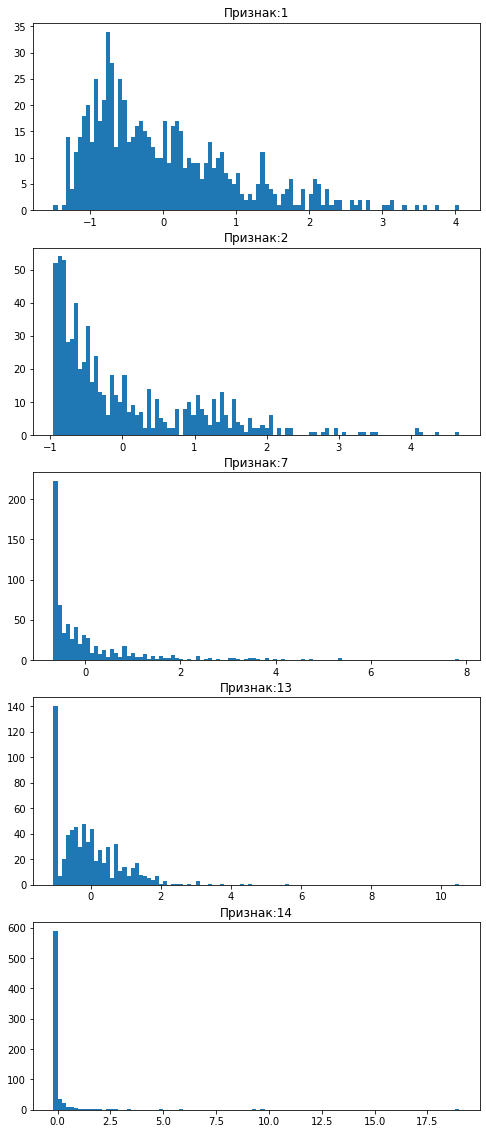

In [125]:
%matplotlib inline
fig, ax = plt.subplots(len(realCols[:-1]), 1, figsize=(8, 20))
for i in range(len(realCols[:-1])):
    # print('Признак:', realCols[i])
    buf = list(dfX[realCols[i]])
    ax[i].hist(buf, bins=100)
    ax[i].set_title('Признак:' + str(realCols[i]))

In [126]:
print('Целевой признак')
# dfY
unique, counts = np.unique(dfY, return_counts=True)
print('Классы:', unique)
print('Распределение:', counts / sum(counts) * 100)

Целевой признак
Классы: [0 1]
Распределение: [44.49275362 55.50724638]


## Выбросы

In [127]:
lower_arr = []
upper_arr = []
out_arr = []
for col in realCols[:-1]:
    buf = np.array(dfX[col])
    q25, q75 = np.percentile(buf, 20), np.percentile(buf, 80)
    cutoff = q75 - q25 * 1.5
    lower, upper = q25 - cutoff, q75 + cutoff
    lower_arr.append(lower)
    upper_arr.append(upper)
    outliers = [i for i in range(len(buf)) if dfX.iloc[i, col] < lower or dfX.iloc[i, col] > upper]
    out_arr.append(outliers)

In [128]:
print(lower_arr, upper_arr)

[-2.854183209461879, -2.9540508064258395, -1.9504898581500358, -3.0394410603463737, -0.4083644292558556] [2.787192467859216, 3.0876408021730635, 1.704739230663928, 2.7746132596763293, 0.13278217189974983]


In [129]:
buf = []
for x in out_arr:
    buf = buf + x
print('Число выбросов:', len(set(buf)))
dfXFiltered = dfX.drop(buf)
dfYFiltered = np.delete(dfY, buf)

Число выбросов: 128


Из-за большого количества выбросов на следующем шаге обучим классификатор на данных без выбросов и на данных с выбросами. По результатам выберем параметры для фильтрации выбросов. Также такое решение обусловлено тем, что судя по графикам и по тому, что данные из области экономики, признаки (числовые) принадлежат распределению с тяжелым хвостом. Следовательно, возникает гипотеза, что данные лучше не выбрасывать.

## SVM

In [130]:
# разбиваем на тестовую и тренировочную выборку
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dfX, dfY, test_size=0.2, random_state=10)
# также делаем разбиение для данных без выбросов
X_train_filt, X_test_filt, y_train_filt, \
y_test_filt = sklearn.model_selection.train_test_split(dfXFiltered,
                                                       dfYFiltered, test_size=0.2, random_state=10)
X_train_mode, X_test_mode, y_train_mode, \
y_test_mode = sklearn.model_selection.train_test_split(dfXmode,
                                                       dfYmode, test_size=0.2, random_state=10)

In [131]:
# функция для подбора параметров классификатора
def chooseBestClf(X_train, X_test, y_train, y_test):
    clf = sklearn.svm.SVC(kernel='linear', gamma='auto', probability=True, random_state=2)
    params = []
    result = []
    params.append({'kernel': ['linear'], 'C': np.arange(1.5, 3.5, 0.2)})
    params.append({'kernel': ['poly'], 'C': np.arange(0.1, 0.3, 0.05),
                   'degree': np.arange(1, 4), 'coef0': np.arange(3, 4, 0.2)})
    params.append({'kernel': ['rbf'], 'C': np.arange(0.6, 2.0, 0.2)})
    params.append({'kernel': ['sigmoid'], 'C': np.arange(0.2, 0.6, 0.1), 'coef0': np.arange(0, 3, 0.5)})
    for param in params:
        gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
        gs.fit(X_train, y_train)
        clf.set_params(**gs.best_params_)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        acc = sklearn.metrics.accuracy_score(y_test, y_pred)
        y_pred_proba = [y[1] for y in y_pred_proba]
        roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
        result.append([gs.best_params_, acc, roc_auc])
    return result

In [132]:
start = time.time()
res = chooseBestClf(X_train, X_test, y_train, y_test)
end = time.time()
svmCVTime = end - start

In [133]:
# параметры классификатора на данных без фильтрации выбросов
res

[[{'C': 2.5, 'kernel': 'linear'}, 0.9202898550724637, 0.9380252100840336],
 [{'C': 0.15000000000000002,
   'coef0': 3.6000000000000005,
   'degree': 2,
   'kernel': 'poly'},
  0.9202898550724637,
  0.9518907563025211],
 [{'C': 1.2000000000000002, 'kernel': 'rbf'},
  0.782608695652174,
  0.8823529411764706],
 [{'C': 0.4000000000000001, 'coef0': 2.0, 'kernel': 'sigmoid'},
  0.5072463768115942,
  0.6605042016806724]]

In [134]:
res[1][0]['probability'] = True
res[1][0]['random_state'] = 2
res[1][0]['gamma'] = 'auto'
resMetrics = []
clf = sklearn.svm.SVC(**res[1][0])
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
svmTime = end - start
y_pred = clf.predict(X_test)
matr = sklearn.metrics.confusion_matrix(y_test, y_pred)
y_pred_proba = clf.predict_proba(X_test)
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
resMetrics.append([svmCVTime, svmTime, matr, acc, roc_auc, res[1][0]])

In [135]:
print(svmCVTime, svmTime)
print(matr, acc, roc_auc)

30.480681657791138 0.06804752349853516
[[62  6]
 [ 5 65]] 0.9202898550724637 0.9518907563025211


In [136]:
start = time.time()
res_filt = chooseBestClf(X_train_filt, X_test_filt, y_train_filt, y_test_filt)
end = time.time()
svmCVTime_filt = end - start

In [137]:
# параметры классификатора на данных с фильтрацией выбросов
res_filt

[[{'C': 1.9, 'kernel': 'linear'}, 0.8938053097345132, 0.9171408250355618],
 [{'C': 0.25000000000000006,
   'coef0': 3.8000000000000007,
   'degree': 2,
   'kernel': 'poly'},
  0.911504424778761,
  0.9377667140825036],
 [{'C': 1.4000000000000004, 'kernel': 'rbf'},
  0.8495575221238938,
  0.9029160739687055],
 [{'C': 0.2, 'coef0': 2.5, 'kernel': 'sigmoid'},
  0.672566371681416,
  0.6625177809388335]]

In [138]:
res_filt[1][0]['probability'] = True
res_filt[1][0]['random_state'] = 2
res_filt[1][0]['gamma'] = 'auto'
resMetrics_filt = []
clf = sklearn.svm.SVC(**res_filt[1][0])
start = time.time()
clf.fit(X_train_filt, y_train_filt)
end = time.time()
svmTime_filt = end - start
y_pred = clf.predict(X_test_filt)
matr = sklearn.metrics.confusion_matrix(y_test_filt, y_pred)
y_pred_proba = clf.predict_proba(X_test_filt)
acc = sklearn.metrics.accuracy_score(y_test_filt, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test_filt, y_pred_proba)
resMetrics_filt.append([svmCVTime_filt, svmTime_filt, matr, acc, roc_auc, res_filt[1][0]])

In [139]:
resMetrics_filt

[[24.866685152053833, 0.062062978744506836, array([[35,  2],
         [ 8, 68]], dtype=int64), 0.911504424778761, 0.9377667140825036, {'C': 0.25000000000000006,
   'coef0': 3.8000000000000007,
   'degree': 2,
   'kernel': 'poly',
   'probability': True,
   'random_state': 2,
   'gamma': 'auto'}]]

In [140]:
start = time.time()
res_mode = chooseBestClf(X_train_mode, X_test_mode, y_train_mode, y_test_mode)
end = time.time()
svmCVTime_mode = end - start
res_mode[1][0]['probability'] = True
res_mode[1][0]['random_state'] = 2
res_mode[1][0]['gamma'] = 'auto'
resMetrics_mode = []
clf = sklearn.svm.SVC(**res_mode[1][0])
start = time.time()
clf.fit(X_train_mode, y_train_mode)
end = time.time()
svmTime_mode = end - start
y_pred = clf.predict(X_test_mode)
matr = sklearn.metrics.confusion_matrix(y_test_mode, y_pred)
y_pred_proba = clf.predict_proba(X_test_mode)
acc = sklearn.metrics.accuracy_score(y_test_mode, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test_mode, y_pred_proba)
resMetrics_mode.append([svmCVTime_mode, svmTime_mode, matr, acc, roc_auc, res_mode[1][0]])
print(res_mode, resMetrics_mode)

[[{'C': 1.5, 'kernel': 'linear'}, 0.9202898550724637, 0.9468487394957984], [{'C': 0.20000000000000004, 'coef0': 3.0, 'degree': 2, 'kernel': 'poly', 'probability': True, 'random_state': 2, 'gamma': 'auto'}, 0.927536231884058, 0.9495798319327731], [{'C': 1.4000000000000004, 'kernel': 'rbf'}, 0.7898550724637681, 0.8888655462184875], [{'C': 0.5000000000000001, 'coef0': 2.0, 'kernel': 'sigmoid'}, 0.5072463768115942, 0.6579831932773109]] [[29.89526081085205, 0.04603242874145508, array([[62,  6],
       [ 4, 66]], dtype=int64), 0.927536231884058, 0.9495798319327731, {'C': 0.20000000000000004, 'coef0': 3.0, 'degree': 2, 'kernel': 'poly', 'probability': True, 'random_state': 2, 'gamma': 'auto'}]]


Лучшие результаты классификатор показывает на данных без фильтрации выбросов, с полиномиальным ядром.

## Случайный лес

Без фильтрации выбросов

In [141]:
def chooseBestTree(X_train, X_test, y_train, y_test):
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=2)
    param = {'criterion': ['gini'], 'max_features': ['sqrt', 'log2'],
             'n_estimators': np.arange(150, 401, 50)}
    gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
    gs.fit(X_train, y_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = [y[1] for y in y_pred_proba]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    res = [gs.best_params_, acc, roc_auc]
    return res

In [142]:
start = time.time()
res = chooseBestTree(X_train, X_test, y_train, y_test)
end = time.time()
rfcCVTime = end - start

In [143]:
res

[{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 300},
 0.8840579710144928,
 0.9545168067226891]

In [144]:
res[0]['random_state'] = 2
clf = sklearn.ensemble.RandomForestClassifier(**res[0])
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
rfcTime = end - start
y_pred = clf.predict(X_test)
matr = sklearn.metrics.confusion_matrix(y_test, y_pred)
y_pred_proba = clf.predict_proba(X_test)
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
resMetrics.append([rfcCVTime, rfcTime, matr, acc, roc_auc, res[0]])

In [145]:
print(resMetrics)

[[30.480681657791138, 0.06804752349853516, array([[62,  6],
       [ 5, 65]], dtype=int64), 0.9202898550724637, 0.9518907563025211, {'C': 0.15000000000000002, 'coef0': 3.6000000000000005, 'degree': 2, 'kernel': 'poly', 'probability': True, 'random_state': 2, 'gamma': 'auto'}], [33.60739326477051, 0.5704050064086914, array([[55, 13],
       [ 3, 67]], dtype=int64), 0.8840579710144928, 0.9545168067226891, {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 2}]]


С фильтрацией выбросов

In [146]:
def chooseBestTree(X_train, X_test, y_train, y_test):
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=2)
    param = {'criterion': ['gini'], 'max_features': ["sqrt", "log2"],
             'n_estimators': np.arange(250, 501, 50)}
    gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
    gs.fit(X_train, y_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = [y[1] for y in y_pred_proba]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    res = [gs.best_params_, acc, roc_auc]
    return res

In [147]:
start = time.time()
res = chooseBestTree(X_train_filt, X_test_filt, y_train_filt, y_test_filt)
end = time.time()
rfcCVTime_filt = end - start
print(res, rfcCVTime_filt)

[{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 350}, 0.8938053097345132, 0.9580369843527738] 42.929511308670044


In [148]:
res[0]['random_state'] = 2
# resMetrics_filt = []
clf = sklearn.ensemble.RandomForestClassifier(**res[0])
start = time.time()
clf.fit(X_train_filt, y_train_filt)
end = time.time()
rfcTime_filt = end - start
y_pred = clf.predict(X_test_filt)
matr = sklearn.metrics.confusion_matrix(y_test_filt, y_pred)
y_pred_proba = clf.predict_proba(X_test_filt)
acc = sklearn.metrics.accuracy_score(y_test_filt, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test_filt, y_pred_proba)
resMetrics_filt.append([rfcCVTime_filt, rfcTime_filt, matr, acc, roc_auc, res[0]])

Заполнение пропусков модой

In [149]:
start = time.time()
res_mode = chooseBestTree(X_train_mode, X_test_mode, y_train_mode, y_test_mode)
end = time.time()
rfcCVTime_mode = end - start
res_mode[0]['random_state'] = 2
clf = sklearn.ensemble.RandomForestClassifier(**res_mode[0])
start = time.time()
clf.fit(X_train_mode, y_train_mode)
end = time.time()
rfcTime_mode = end - start
y_pred = clf.predict(X_test_mode)
matr = sklearn.metrics.confusion_matrix(y_test_mode, y_pred)
y_pred_proba = clf.predict_proba(X_test_mode)
acc = sklearn.metrics.accuracy_score(y_test_mode, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test_mode, y_pred_proba)
resMetrics_mode.append([rfcCVTime_mode, rfcTime_mode, matr, acc, roc_auc, res_mode[0]])
print(res_mode[0], resMetrics_mode[-1])

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 400, 'random_state': 2} [44.37853980064392, 0.740515947341919, array([[56, 12],
       [ 3, 67]], dtype=int64), 0.8913043478260869, 0.9555672268907562, {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 400, 'random_state': 2}]


## AdaBoost

Без фильтрации выбросов

In [150]:
def chooseBestParams(X_train, X_test, y_train, y_test):
    clf = sklearn.ensemble.AdaBoostClassifier(learning_rate=0.9, random_state=2)
    est1 = sklearn.tree.DecisionTreeClassifier(max_depth=10, random_state=2)
    est2 = sklearn.svm.SVC(kernel='poly', degree=2, gamma='auto', probability=True)
    param = {'base_estimator': [est1], 'base_estimator__max_depth': np.arange(5, 9),
             'base_estimator__max_features': range(3, 8, 2),
             'learning_rate': np.arange(0.8, 0.92, 0.02), 'n_estimators': np.arange(130, 181, 10)}
    gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
    gs.fit(X_train, y_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = [y[1] for y in y_pred_proba]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    res = [gs.best_params_, acc, roc_auc]
    return res

In [151]:
start = time.time()
res = chooseBestParams(X_train, X_test, y_train, y_test)
end = time.time()
abcCVTime = end - start
print(res)

[{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2, splitter='best'), 'base_estimator__max_depth': 6, 'base_estimator__max_features': 5, 'learning_rate': 0.8800000000000001, 'n_estimators': 160}, 0.8333333333333334, 0.9258403361344538]


In [152]:
print(abcCVTime)

823.5769817829132


In [153]:
res[0]['random_state'] = 2
# buf = res[0].copy()
del res[0]['base_estimator__max_depth']
del res[0]['base_estimator__max_features']
clf = sklearn.ensemble.AdaBoostClassifier(**res[0])
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
abcTime = end - start
y_pred = clf.predict(X_test)
matr = sklearn.metrics.confusion_matrix(y_test, y_pred)
y_pred_proba = clf.predict_proba(X_test)
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
resMetrics.append([abcCVTime, abcTime, matr, acc, roc_auc, res[0]])

In [154]:
print(resMetrics)

[[30.480681657791138, 0.06804752349853516, array([[62,  6],
       [ 5, 65]], dtype=int64), 0.9202898550724637, 0.9518907563025211, {'C': 0.15000000000000002, 'coef0': 3.6000000000000005, 'degree': 2, 'kernel': 'poly', 'probability': True, 'random_state': 2, 'gamma': 'auto'}], [33.60739326477051, 0.5704050064086914, array([[55, 13],
       [ 3, 67]], dtype=int64), 0.8840579710144928, 0.9545168067226891, {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 2}], [823.5769817829132, 0.4092867374420166, array([[48, 20],
       [ 3, 67]], dtype=int64), 0.8333333333333334, 0.9258403361344538, {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                 

С фильтрацией выбросов

In [155]:
def chooseBestParams(X_train, X_test, y_train, y_test):
    clf = sklearn.ensemble.AdaBoostClassifier(learning_rate=0.9, random_state=2)
    est1 = sklearn.tree.DecisionTreeClassifier(max_depth=10, random_state=2)
    est2 = sklearn.svm.SVC(kernel='poly', degree=2, gamma='auto', probability=True)
    param = {'base_estimator': [est1], 'base_estimator__max_depth': np.arange(7, 10),
             'base_estimator__max_features': range(1, 5),
             'learning_rate': np.arange(0.8, 0.92, 0.02), 'n_estimators': np.arange(50, 91, 10)}
    gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
    gs.fit(X_train, y_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = [y[1] for y in y_pred_proba]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    res = [gs.best_params_, acc, roc_auc]
    return res

In [156]:
start = time.time()
res = chooseBestParams(X_train_filt, X_test_filt, y_train_filt, y_test_filt)
end = time.time()
abcCVTime_filt = end - start
print(res)

[{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2, splitter='best'), 'base_estimator__max_depth': 8, 'base_estimator__max_features': 3, 'learning_rate': 0.8800000000000001, 'n_estimators': 80}, 0.8584070796460177, 0.933854907539118]


In [157]:
res[0]['random_state'] = 2
del res[0]['base_estimator__max_depth']
del res[0]['base_estimator__max_features']
clf = sklearn.ensemble.AdaBoostClassifier(**res[0])
start = time.time()
clf.fit(X_train_filt, y_train_filt)
end = time.time()
abcTime_filt = end - start
y_pred = clf.predict(X_test_filt)
matr = sklearn.metrics.confusion_matrix(y_test_filt, y_pred)
y_pred_proba = clf.predict_proba(X_test_filt)
acc = sklearn.metrics.accuracy_score(y_test_filt, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test_filt, y_pred_proba)
resMetrics_filt.append([abcCVTime_filt, abcTime_filt, matr, acc, roc_auc, res[0]])

С пропусками, заполненными модой

In [158]:
def chooseBestParams(X_train, X_test, y_train, y_test):
    clf = sklearn.ensemble.AdaBoostClassifier(learning_rate=0.9, random_state=2)
    est1 = sklearn.tree.DecisionTreeClassifier(max_depth=10, random_state=2)
    est2 = sklearn.svm.SVC(kernel='poly', degree=2, gamma='auto', probability=True)
    param = {'base_estimator': [est1], 'base_estimator__max_depth': np.arange(3, 9),
             'base_estimator__max_features': range(1, 5),
             'learning_rate': np.arange(0.8, 0.92, 0.02), 'n_estimators': np.arange(50, 91, 10)}
    gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
    gs.fit(X_train, y_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = [y[1] for y in y_pred_proba]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    res = [gs.best_params_, acc, roc_auc]
    return res

In [159]:
start = time.time()
res = chooseBestParams(X_train_mode, X_test_mode, y_train_mode, y_test_mode)
end = time.time()
abcCVTime_mode = end - start
res[0]['random_state'] = 2
del res[0]['base_estimator__max_depth']
del res[0]['base_estimator__max_features']
clf = sklearn.ensemble.AdaBoostClassifier(**res[0])
start = time.time()
clf.fit(X_train_mode, y_train_mode)
end = time.time()
abcTime_mode = end - start
y_pred = clf.predict(X_test_mode)
matr = sklearn.metrics.confusion_matrix(y_test_mode, y_pred)
y_pred_proba = clf.predict_proba(X_test_mode)
acc = sklearn.metrics.accuracy_score(y_test_mode, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test_mode, y_pred_proba)
resMetrics_mode.append([abcCVTime_mode, abcTime_mode, matr, acc, roc_auc, res[0]])
print(res, resMetrics_mode[-1])

[{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2, splitter='best'), 'learning_rate': 0.9000000000000001, 'n_estimators': 80, 'random_state': 2}, 0.782608695652174, 0.9119747899159664] [613.9499917030334, 0.18613147735595703, array([[44, 24],
       [ 6, 64]], dtype=int64), 0.782608695652174, 0.9119747899159664, {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf

## XGBoost

In [160]:
from xgboost import XGBClassifier

In [161]:
def chooseBestParamsXGB(X_train, X_test, y_train, y_test):
    clf = XGBClassifier(random_state=2)
    param = {'max_depth': [2, 3, 4, 5], 'learning_rate': [0.1, 0.05, 0.01],
             'n_estimators': [50, 100, 150]}
    gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
    gs.fit(X_train, y_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = [y[1] for y in y_pred_proba]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    res = [gs.best_params_, acc, roc_auc]
    return res

Без фильтрации выбросов

In [162]:
start = time.time()
res = chooseBestParamsXGB(X_train, X_test, y_train, y_test)
end = time.time()
xgbCVTime = end - start
res[0]['random_state'] = 2
clf = XGBClassifier(**res[0])
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
xgbTime = end - start
y_pred = clf.predict(X_test)
matr = sklearn.metrics.confusion_matrix(y_test, y_pred)
y_pred_proba = clf.predict_proba(X_test)
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
resMetrics.append([xgbCVTime, xgbTime, matr, acc, roc_auc, res[0]])
print(res, resMetrics[-1])

[{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'random_state': 2}, 0.8405797101449275, 0.9455882352941176] [15.04369044303894, 0.06004214286804199, array([[52, 16],
       [ 6, 64]], dtype=int64), 0.8405797101449275, 0.9455882352941176, {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'random_state': 2}]


С фильтрацией выбросов

In [163]:
def chooseBestParamsXGB(X_train, X_test, y_train, y_test):
    clf = XGBClassifier(random_state=2)
    param = {'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.01, 0.001],
             'n_estimators': [200, 250, 300]}
    gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
    gs.fit(X_train, y_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = [y[1] for y in y_pred_proba]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    res = [gs.best_params_, acc, roc_auc]
    return res

In [164]:
start = time.time()
res = chooseBestParamsXGB(X_train_filt, X_test_filt, y_train_filt, y_test_filt)
end = time.time()
xgbCVTime_filt = end - start
res[0]['random_state'] = 2
clf = XGBClassifier(**res[0])
start = time.time()
clf.fit(X_train_filt, y_train_filt)
end = time.time()
xgbTime_filt = end - start
y_pred = clf.predict(X_test_filt)
matr = sklearn.metrics.confusion_matrix(y_test_filt, y_pred)
y_pred_proba = clf.predict_proba(X_test_filt)
acc = sklearn.metrics.accuracy_score(y_test_filt, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test_filt, y_pred_proba)
resMetrics_filt.append([xgbCVTime_filt, xgbTime_filt, matr, acc, roc_auc, res[0]])
print(res, resMetrics_filt[-1])

[{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 250, 'random_state': 2}, 0.911504424778761, 0.9688833570412518] [23.966004610061646, 0.24717354774475098, array([[32,  5],
       [ 5, 71]], dtype=int64), 0.911504424778761, 0.9688833570412518, {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 250, 'random_state': 2}]


С пропусками, заполненными модой

In [165]:
def chooseBestParamsXGB(X_train, X_test, y_train, y_test):
    clf = XGBClassifier(random_state=2)
    param = {'max_depth': [1, 2, 3], 'learning_rate': [0.1, 0.01, 0.001],
             'n_estimators': np.arange(700, 801, 50)}
    gs = sklearn.model_selection.GridSearchCV(clf, param, scoring='roc_auc', cv=5, iid=False)
    gs.fit(X_train, y_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = [y[1] for y in y_pred_proba]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    res = [gs.best_params_, acc, roc_auc]
    return res

In [166]:
start = time.time()
res = chooseBestParamsXGB(X_train_mode, X_test_mode, y_train_mode, y_test_mode)
end = time.time()
xgbCVTime_mode = end - start
res[0]['random_state'] = 2
clf = XGBClassifier(**res[0])
start = time.time()
clf.fit(X_train_mode, y_train_mode)
end = time.time()
xgbTime_mode = end - start
y_pred = clf.predict(X_test_mode)
matr = sklearn.metrics.confusion_matrix(y_test_mode, y_pred)
y_pred_proba = clf.predict_proba(X_test_mode)
acc = sklearn.metrics.accuracy_score(y_test_mode, y_pred)
y_pred_proba = [y[1] for y in y_pred_proba]
roc_auc = sklearn.metrics.roc_auc_score(y_test_mode, y_pred_proba)
resMetrics_mode.append([xgbCVTime_mode, xgbTime_mode, matr, acc, roc_auc, res[0]])
print(res, resMetrics_mode[-1])

[{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 750, 'random_state': 2}, 0.8623188405797102, 0.9527310924369747] [54.744436502456665, 0.45032238960266113, array([[54, 14],
       [ 5, 65]], dtype=int64), 0.8623188405797102, 0.9527310924369747, {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 750, 'random_state': 2}]


## Результаты (отчет)

Конфигурация компьютера: Intel Core i5-4210U, 8GB RAM

В следующей таблице представлены результаты использования SVM, RandomForest, AdaBoost, XGBoost на трех версиях датасета:
1. без приставки к методу - датасет с пропусками, заполненными значениями из наиболее близкой по евклидову расстоянию строки;
2. с приставкой Filt - аналогично пункту 1, но в данных дополнительно отфильтрованы выбросы;
3. с приставкой Mode - пропущенные значения заполнялись модой для категориальных признаков и медианой для числовых.

In [169]:
res_columns = ['Grid search time, s', 'Training time, s', 'Accuracy', 'ROC-AUC', 'Params']
res_indices = ['SVM', 'RandomForest', 'AdaBoost', 'XGBoost', 'SVMFilt','RandomForestFilt',
               'AdaBoostFilt', 'XGBoostFilt', 'SVMMode','RandomForestMode',
               'AdaBoostMode', 'XGBoostMode']
resMetr = np.vstack([np.array(resMetrics), np.array(resMetrics_filt), np.array(resMetrics_mode)])

result_df = pd.DataFrame(resMetr[:, [0, 1, 3, 4, 5]], index=res_indices, columns=res_columns)
result_df

,"Grid search time, s","Training time, s",Accuracy,ROC-AUC,Params
SVM,30.4807,0.0680475,0.92029,0.951891,"{'C': 0.15000000000000002, 'coef0': 3.60000000..."
RandomForest,33.6074,0.570405,0.884058,0.954517,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
AdaBoost,823.577,0.409287,0.833333,0.92584,{'base_estimator': DecisionTreeClassifier(clas...
XGBoost,15.0437,0.0600421,0.84058,0.945588,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
SVMFilt,24.8667,0.062063,0.911504,0.937767,"{'C': 0.25000000000000006, 'coef0': 3.80000000..."
RandomForestFilt,42.9295,0.695492,0.893805,0.958037,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
AdaBoostFilt,279.893,0.176127,0.858407,0.933855,{'base_estimator': DecisionTreeClassifier(clas...
XGBoostFilt,23.966,0.247174,0.911504,0.968883,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est..."
SVMMode,29.8953,0.0460324,0.927536,0.94958,"{'C': 0.20000000000000004, 'coef0': 3.0, 'degr..."
RandomForestMode,44.3785,0.740516,0.891304,0.955567,"{'criterion': 'gini', 'max_features': 'sqrt', ..."


Как видно из таблицы, в большинстве случаев быстрее всего обучается SVM, а медленнее всего AdaBoost. При этом наибольший результат по accuracy и roc-auc на первой и третьей версии датасета получается при использовании SVM с полиномиальным ядром, а на датасете с отфильтрованными выбросами лучше всего работает XGBoost.

В следующей ячейки показаны confusion matrix для всех использованных алгоритмов. В итоге, смотря на метрики, можно сделать следующие выводы:
1. На данном датасете лучше всего работает SVM с полиномиальным ядром;
2. Заполнение пропусков модой и при помощи наиболее схожих векторов практически не дают различий по итоговой метрике (изменяется лишь класс одного элемента, что видно из confusion matrix);
3. Фильтрация выбросов в данном даасете не играет существенной роли - это может быть связано с тем, что данные взяты из экономики, и, судя по графикам, имеют распределение с тяжелым хвостом.

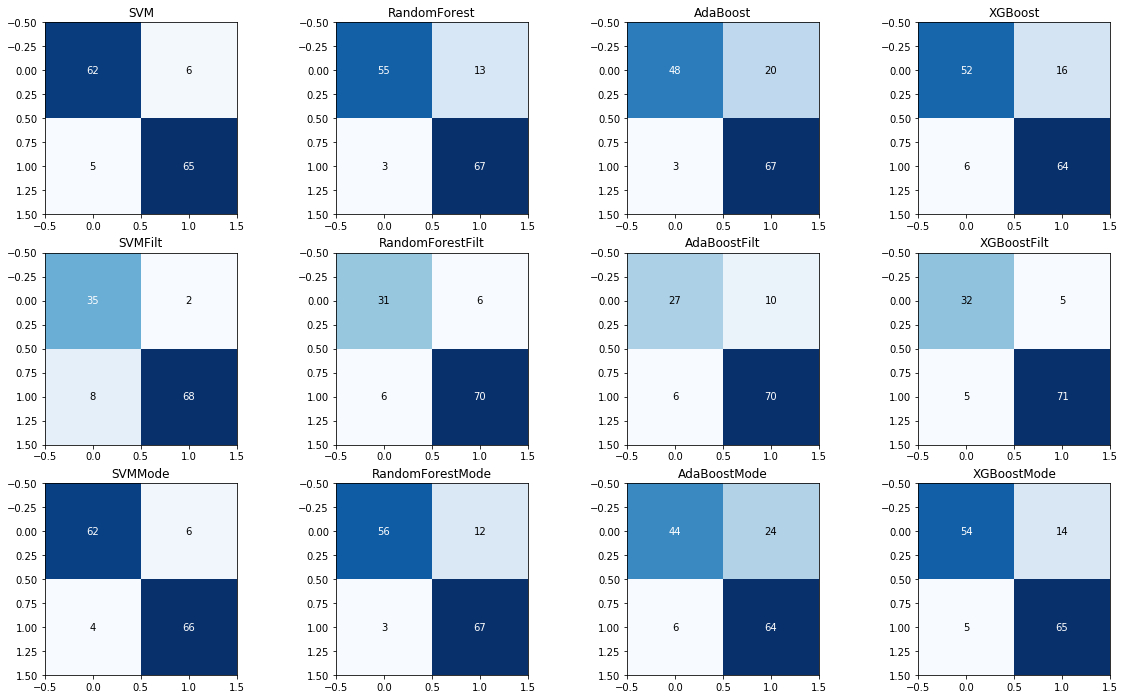

In [170]:
%matplotlib inline
matrices = resMetr[:, [2]]
fig, ax = plt.subplots(3, 4, figsize=(20, 12))
for m in range(3):
    for i in range(4):
        # print('Признак:', realCols[i])
        # buf = list(dfX[realCols[i]])
        # print(matrices[i][0])
        ax[m][i].imshow(matrices[i + m * 4][0], interpolation='nearest', cmap=plt.cm.Blues)
        cm = matrices[i + m * 4][0]
        normalize = False
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for k in range(2):
            for j in range(2):
                ax[m][i].text(j, k, format(cm[k][j], fmt),
                        ha="center", va="center",
                        color="white" if cm[k, j] > thresh else "black")
        ax[m][i].set_title(res_indices[i + m * 4])